![oi_masterdados](img/oi_masterdados2.png)

# Job Change of Data Scientists

## Este projeto tem o propósito de predizer quem irá para um novo emprego. Para isso, utilizaremos um modelo de classificação supervisionado.

# GRUPO 02

# ●  Iura Teixeira Xavier
# ●  Adames Oliveira
# ●  Fabyo Sousa Ramos

# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining

### CRISP-DM is a data mining methodology in cyclic format, which guide the discovery of knowledge for decision making on large volume data.

![Crisp 1](img/crisp1.jpg)

# DATASET

## Job Change of Data Scientists

Context and Content
A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

This dataset designed to understand the factors that lead a person to leave current job for HR researches too. By model(s) that uses the current credentials,demographics,experience data you will predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

The whole data divided to train and test . Target isn't included in test but the test target values data file is in hands for related tasks. A sample submission correspond to enrollee_id of test set provided too with columns : enrollee _id , target

### ●  The dataset is imbalanced.
### ●  Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
### ●  Missing imputation can be a part of your pipeline as well.

## Features

### ●  enrollee_id : Unique ID for candidate

### ●  city: City code

### ●  city_ development _index : Developement index of the city (scaled)

### ●  gender: Gender of candidate

### ●  relevent_experience: Relevant experience of candidate

### ●  enrolled_university: Type of University course enrolled if any

### ●  education_level: Education level of candidate

### ●  major_discipline :Education major discipline of candidate

### ●  experience: Candidate total ### - experience in years

### ●  company_size: No of employees in current employer's company

### ●  company_type : Type of current employer

### ●  lastnewjob: Difference in years between previous job and current job

### ●  training_hours: training hours completed

### ●  target: 0 – Not looking for job change, 1 – Looking for a job change

## Objetivos

### Predict the probability of a candidate will work for the company
### Interpret model(s) such a way that illustrate which features affect candidate decision

# 0.0 IMPORTS

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle
import imblearn
import keras
import random
import itertools
import collections
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats as ss
from datetime                import timedelta
from boruta                  import BorutaPy
from scipy.stats import ks_2samp
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute          import SimpleImputer
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from keras.models            import Sequential
from keras.layers            import Dense
from keras.wrappers.scikit_learn  import KerasClassifier
from xgboost                 import XGBClassifier, XGBRFClassifier
from imblearn.over_sampling  import SMOTE
from imblearn.combine        import SMOTETomek
from pandas_profiling        import ProfileReport


#warnings.filterwarnings('ignore')

# 1.0 HELPER FUNCTIONS

In [16]:
def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )

def check_nan(df):
    '''
    Takes df
    Checks nulls
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent*100], axis=1, keys=['Total Missing', 'Percent'])
  
        print('● Dataset contains NaN values.\n')
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('● Dataset does not contains NaN values. No NaN found.')


def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g


def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2_corr/n) / ( min( k_corr-1, r_corr-1) ) )


def plot_roc_curve(fpr, tpr, auc):
    plt.plot(fpr, tpr)
    plt.title('ROC Curve - AUC: {}'.format(auc))
    plt.xlabel('1 - Especificidade')
    plt.ylabel('Sensibilidade')
    plt.grid(True)
    plt.show()


def udf_cross_validation(X_train, y_train, classifier_name, classifier, num_folds, n_repeats, verbose=False):
    i                 = 1
    accuracy_list     = []
    balanced_acc_list = []
    kappa_acc_list    = []
    conf_matrix       = []
    mcc_list          = []
    auc_list          = []
    fpr_list          = []
    tpr_list          = []
    thresholds_list   = []        
    rskf              = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=n_repeats, random_state=36851234)
    
    # generate k-fold
    for train_idx, val_idx in rskf.split( X_train, y_train ):
        if verbose:
            print( '\n****** Running {}/{} ******'.format(i, n_repeats*num_folds) )
            
        # get training fold
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx].values.ravel()
        
        # get validation fold
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        # training model
        classifier.fit(X_train_fold, y_train_fold)

        # predicting
        y_pred  = classifier.predict(X_val_fold)
        y_proba = classifier.predict_proba(X_val_fold)
        
        # metrics
        ## accuracy_score - Total of corrects predictions, main diagonal of the confusion matrix DIVIDED by the total of predictions
        score = accuracy_score(y_val_fold, y_pred)
        accuracy_list.append(score)
        
        ## Balanced Accuracy - Very goog to multi class analyses. Get all classes accuracy and extract the average. 
        balanced_acc = balanced_accuracy_score(y_val_fold, y_pred)
        balanced_acc_list.append(balanced_acc)
        
        ## Kappa score
        kappa_acc = cohen_kappa_score( y_val_fold, y_pred )
        kappa_acc_list.append(kappa_acc)
        
        # matthews_corrcoef - First, It is a metric that takes into account all the possibilities of a binary classification problem (TP, TN, FP and FN).
        #                            It is robust to unbalanced datasets. The result of it is a normalized coefficient between -1 and 1 that is easy to interpret.
        #
        #                            -1 : the closer your MCC is to -1, the worse your classifier is. In other words, he is making more mistakes than he gets right.
        #                            +1 : on the other hand, the closer to +1, the better your classifier. That is, he is hitting more than he misses.
        #                             0 : when the coefficient is close to 0, it shows that the classifier is just "kicking" the most frequent class (es).
        
        mcc = matthews_corrcoef( y_val_fold, y_pred )
        mcc_list.append( mcc )
        
        ## roc curve
        y_proba = y_proba[:, 1]
        auc = roc_auc_score(y_val_fold, y_proba)
        fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
        auc_list.append(auc)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thresholds_list.append(thresholds)
        
        conf_matrix.append( confusion_matrix(y_val_fold, y_pred) ) 
        i+=1
        
    # metrics ------------------------------------------------------------------------------------------------------
    
    # confusion matrix
    cnf_matrix = np.mean(conf_matrix, axis=0)
    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    # Precision
    precision = TP / ( TP + FP ) 
    
    # Recall
    recall = TP / ( TP + FN )
    
    # F1 Score
    F1 = 2 * (precision * recall) / (precision + recall)
    
    # Specificity - How good the algorithm is at hitting the negative class. In other words: "Of the negative samples, how many did the algorithm get right?
    specificity = TN / ( TN+FP )

    # NPV - Negative Predictive Value - How much you trust the negative class prediction. In other words: “Of the samples that my algorithm said were negative, how many really are?
    npv = TN / (TN + FN)
    
    # plot confusion matrix
    udf_plot_confusion_matrix(cnf_matrix, [0, 1], normalize=False)
    
    # plot roc curve
    plot_roc_curve(fpr, tpr, np.round( np.mean(auc_list), 2 ).astype(str))

    print( 'Confusion matrix:\n{}\n'.format( cnf_matrix ) )
    
    df_classifier_result = pd.DataFrame(
        {
            'Classifier Name'                  : classifier_name,
            'Accuracy score'                   : np.round( np.mean(accuracy_list), 2 ).astype(str),
            'Precision score'                  : np.round( precision, 2 ).astype(str),
            'Recall score'                     : np.round( recall, 2 ).astype(str),
            'F1 score'                         : np.round( F1, 2 ).astype(str),
            'Specificity'                      : np.round( specificity, 2 ).astype(str),
            'NPV'                              : np.round( npv, 2 ).astype(str),
            'Balanced Accuracy score'          : np.round( np.mean(balanced_acc_list), 2 ).astype(str),
            'AUC'                              : np.round( np.mean(auc_list), 2 ).astype(str),
            'Kappa score'                      : np.round( np.mean(kappa_acc_list), 2 ).astype(str),
            'Matthews Correlation Coefficient' : np.round( np.mean(mcc_list), 2 ).astype(str)
        },
        index=[0]
    )
        
    return df_classifier_result


def udf_plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 2.0 DATA LOADING

In [6]:
# load data
df0 = pd.read_csv('aug_train.csv')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [7]:
df0.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# 3.0 DATA PREPROCESSING

In [8]:
df1 = df0.copy()

## 3.1 Data Dimensions

In [13]:
df_shape = df1.shape
print('● Dataset contains {} rows and {} columns.'.format(df_shape[0], df_shape[1]))

● Dataset contains 19158 rows and 14 columns.


## 3.2 Detecting Missing Values

In [15]:
# check "not available" values
#df1.isna().sum()

check_nan(df1)

● Dataset contains NaN values.

Total and Percentage of NaN:
                      Total Missing    Percent
company_type                  6140  32.049274
company_size                  5938  30.994885
gender                        4508  23.530640
major_discipline              2813  14.683161
education_level                460   2.401086
last_new_job                   423   2.207955
enrolled_university            386   2.014824
experience                      65   0.339284


## 3.3 Missing Values Distributions

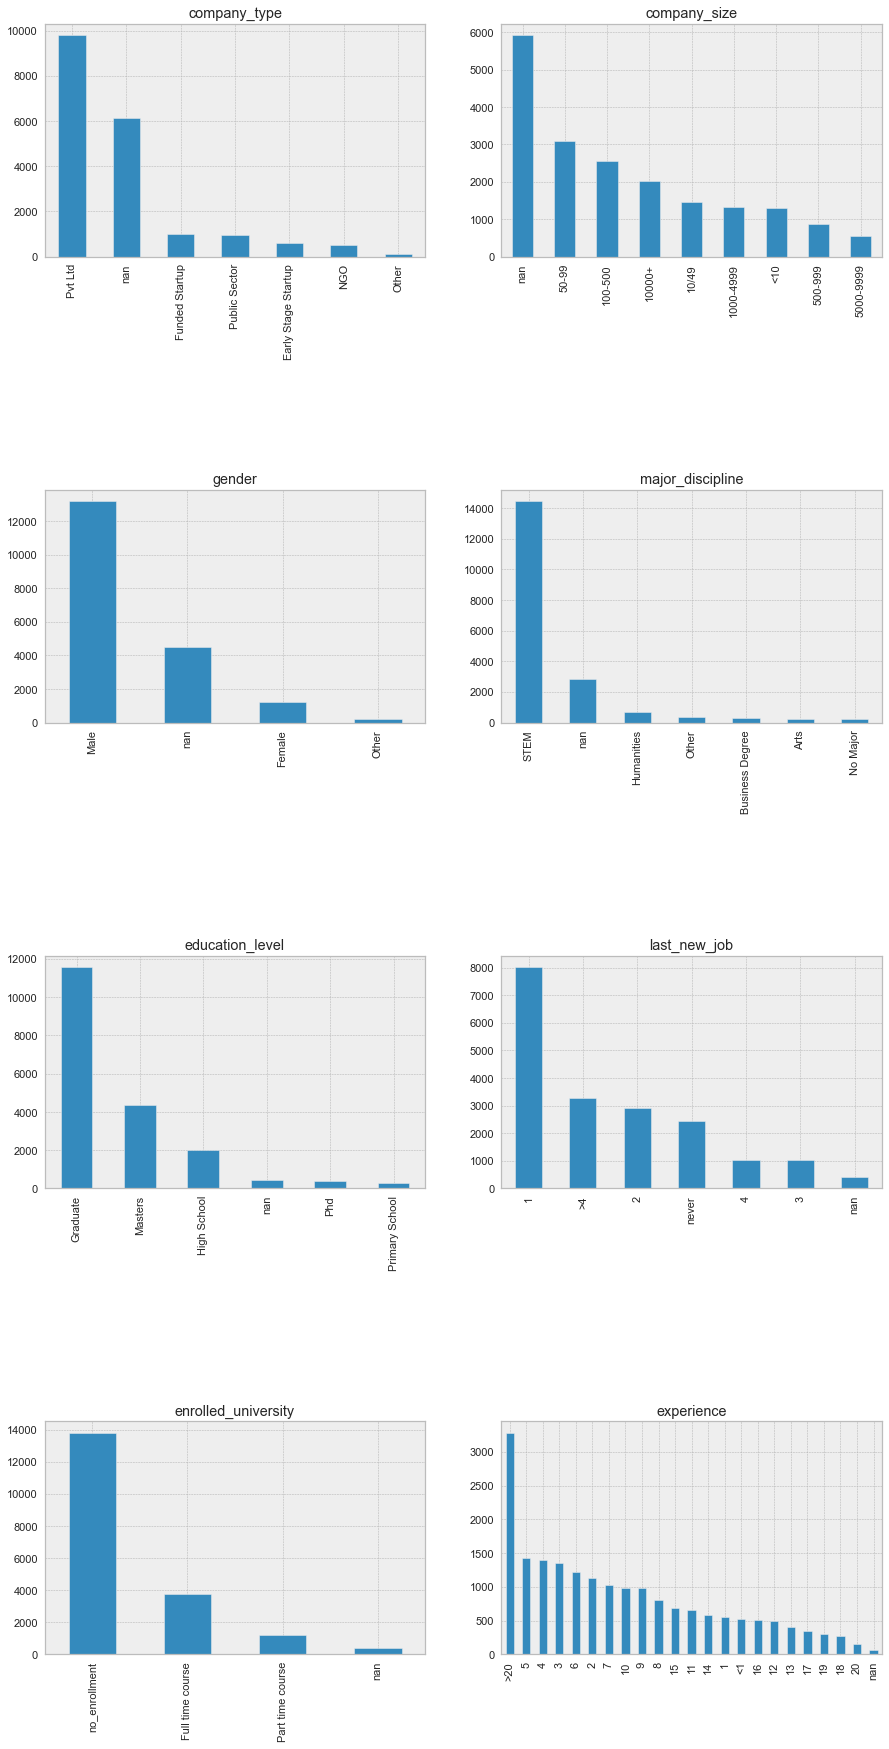

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(15,30))
plt.subplots_adjust(hspace=1) #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

# using value_counts(dropna=False) to show missing values

df1['company_type'].value_counts(dropna=False).plot(kind="bar", title='company_type', ax=axes[0,0]);
df1['company_size'].value_counts(dropna=False).plot(kind="bar", title='company_size', ax=axes[0,1]);
df1['gender'].value_counts(dropna=False).plot(kind="bar", title='gender', ax=axes[1,0]);
df1['major_discipline'].value_counts(dropna=False).plot(kind="bar", title='major_discipline', ax=axes[1,1]);
df1['education_level'].value_counts(dropna=False).plot(kind="bar", title='education_level', ax=axes[2,0]);
df1['last_new_job'].value_counts(dropna=False).plot(kind="bar", title='last_new_job', ax=axes[2,1]);
df1['enrolled_university'].value_counts(dropna=False).plot(kind="bar", title='enrolled_university', ax=axes[3,0]);
df1['experience'].value_counts(dropna=False).plot(kind="bar", title='experience', ax=axes[3,1]);


## 3.4 Fillout Missing Values

### How to treat missing values ? Why ?

In [18]:
# company_type
df1['company_type'].fillna('Unknown', inplace = True)

# company_size
df1['company_size'].fillna('Unknown', inplace = True)

# gender, replace the missing value by the most frequent value
df1['gender'].fillna(df1['gender'].mode()[0], inplace = True)

# major_discipline, replace the missing value by the most frequent value
df1['major_discipline'].fillna(df1['major_discipline'].mode()[0], inplace = True)

# education_level, replace the missing value by the most frequent value
df1['education_level'].fillna(df1['education_level'].mode()[0], inplace = True)

# last_new_job, replace the missing value by the most frequent value
df1['last_new_job'].fillna(df1['last_new_job'].mode()[0], inplace = True)

# enrolled_university, replace the missing value by the most frequent value
df1['enrolled_university'].fillna(df1['enrolled_university'].mode()[0], inplace = True)

# experience, replace the missing value by the most frequent value
df1['experience'].fillna(df1['experience'].mode()[0], inplace = True)

In [19]:
check_nan(df1)

● Dataset does not contains NaN values. No NaN found.


# 4.0 EXPLORATORY DATA ANALYSIS

## 4.1 Numerical Attributes Statistics

In [48]:
df1.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


### ● Temos 3 variáveis númericas, sendo 2 explicativas (city_development_index, training_hours) e a variável dependente "target".

### ● A Média da variável target informa que 25%( percentual de ocorrência do evento) mudaram de emprego.

### 4.1.1 Univariate Analysis

**Histograma**

**Definição:** uma uma representação gráfica em formato de retângulos cuja área é proporcional à frequência de uma variável quantitativa e cuja largura é igual ao intervalo de classe.

**Para que serve:** Um histograma é uma representação gráfica da distribuição de uma variável quantitativa contínua. Com o histograma pode-se visualizar a dispersão/concentração dos dados, bem como a assimetria/simetria dos dados. É muito utilizado para visualizar toda a distribuição de uma variável quantitativa. Foi introduzida pela primeira vez por Karl Pearson (OBS - É muito parecido com o gráfico de barras).

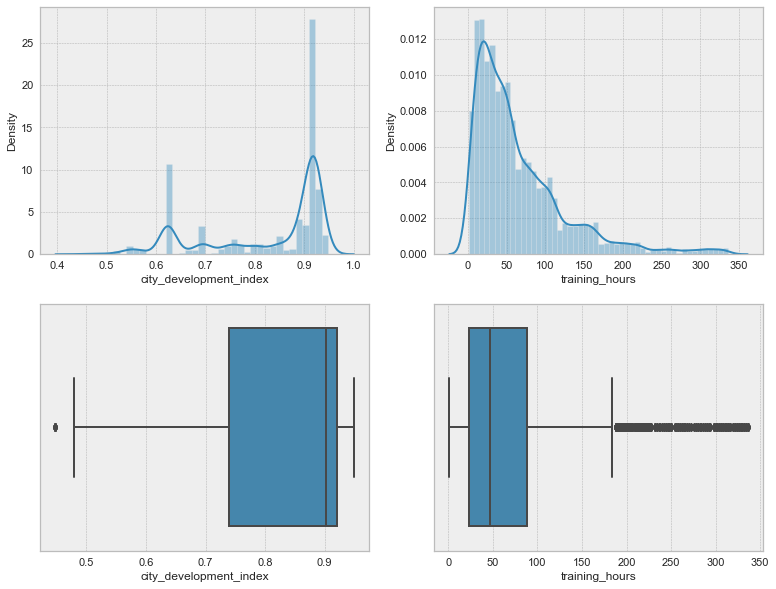

In [86]:
# mount grid 3 rows x 3 cols to receive charts
grid = GridSpec(2, 3)

# Distribution
plt.subplot(grid[0,0])
sns.distplot( df1['city_development_index'] )

plt.subplot(grid[0,1])
sns.distplot( df1['training_hours'] )

# Boxplot
plt.subplot(grid[1,0])
sns.boxplot( x=df1['city_development_index'])

plt.subplot(grid[1,1])
sns.boxplot( x=df1['training_hours'] );


### ●  Nossas variáveis não possuem uma distribuição normal.

### ●  Temos outliers nas variáveis preditoras city_development_index e training_hours.

### 4.1.2 Response Variable

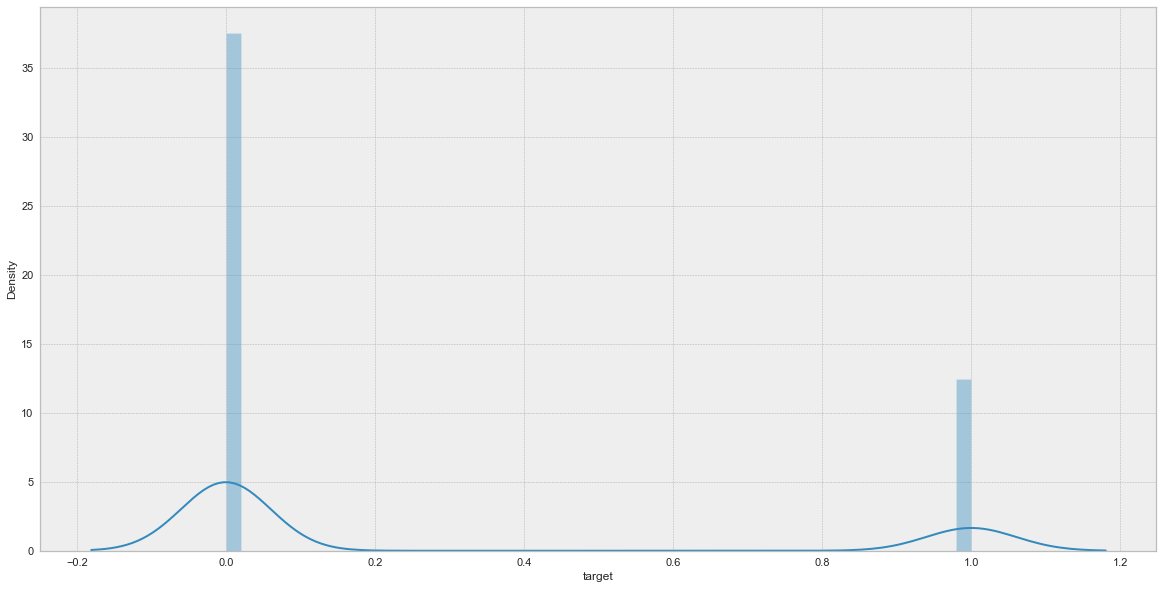

In [87]:
sns.distplot(df1['target']);

#### ● We have an imbalanced dataset. We have to balanced the dataset, using undersamplig or oversampling techniques, to get a better model.

## 4.2 Categorical Variable

### ● Nosso Dataset tem muitas variáveis categóricas (Nominais, Ordinais, Binárias), algumas com alta cardinalidade.

In [27]:
cat_attributes = df1.select_dtypes( include=['object', 'category'] )

print('● Variáveis categóricas e quantidades de categorias.\n')
for col in cat_attributes:
    print('● {}: {}'.format(col, len( df1[col].unique() ) ) )

● Variáveis categóricas e quantidades de categorias.

● city: 123
● gender: 3
● relevent_experience: 2
● enrolled_university: 3
● education_level: 5
● major_discipline: 6
● experience: 22
● company_size: 9
● company_type: 7
● last_new_job: 6


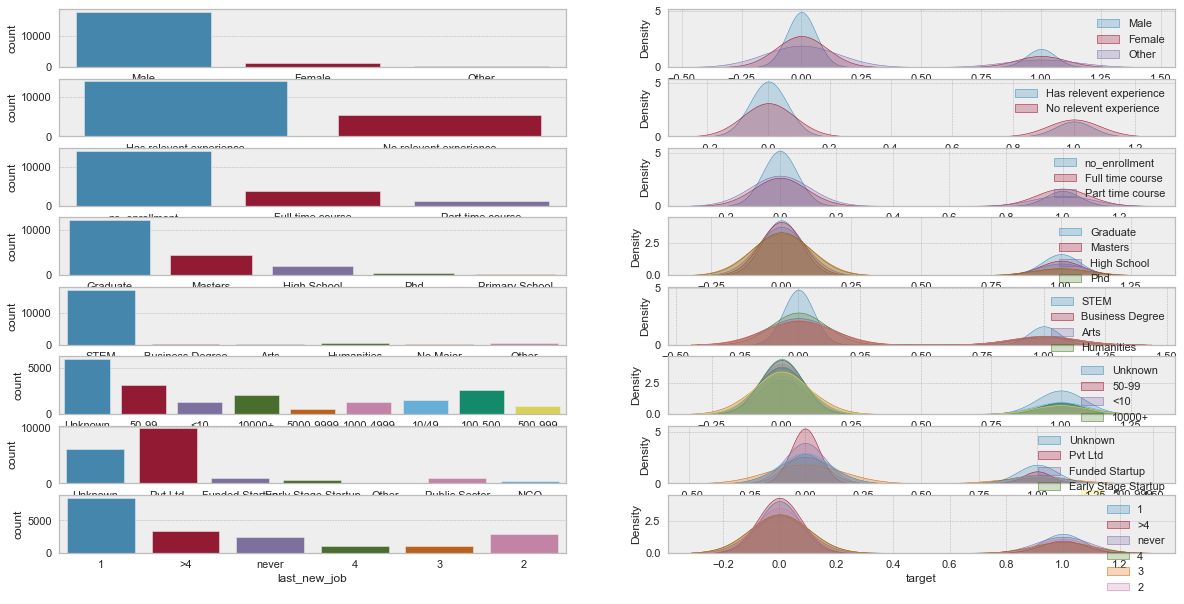

In [88]:
cat_list = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']

i = 0
ilines_plot = 8
for col in cat_list:
    i += 1
    plt.subplot(ilines_plot, 2, i)
    i += 1
    sns.countplot(df1[col])
    plt.subplot(ilines_plot, 2, i)
    for categ in df1[col].unique():
        sns.kdeplot(df1[df1[col] == categ]['target'], label=categ, shade=True) 
    plt.legend()

### 4.2 What about statistics above ?

## 4.3 Bivariate Analysis

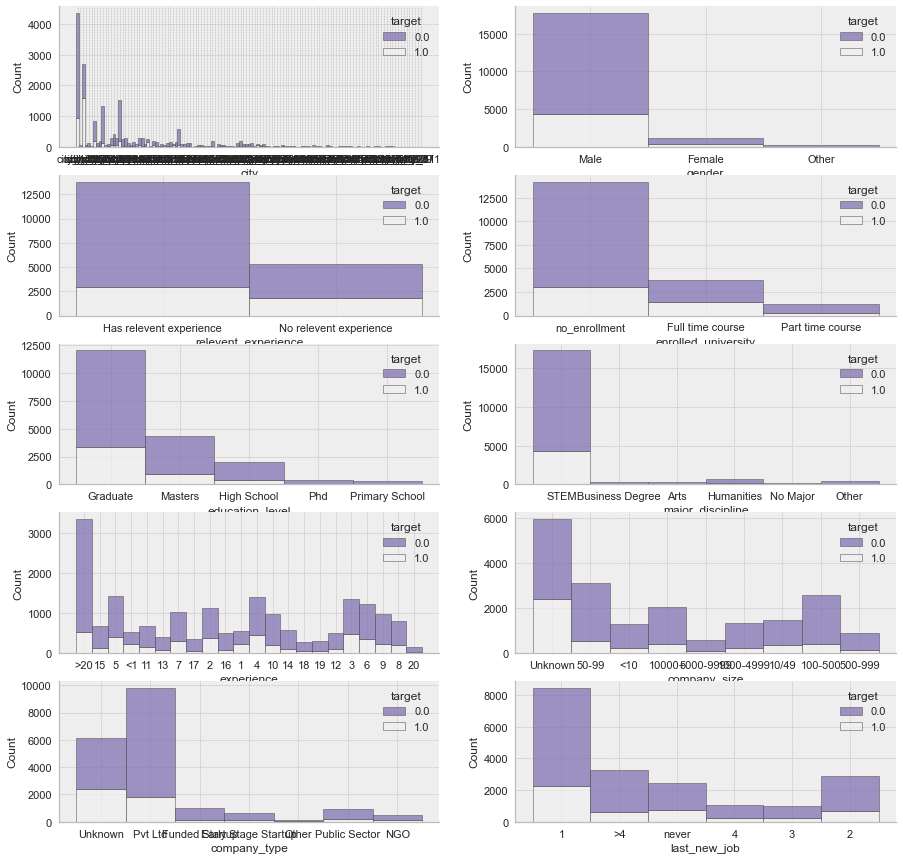

In [84]:
cat_list = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

f, ax = plt.subplots(5,2,figsize=(15, 15))

sns.despine(f)

i = 0
iline = 0
ax_col = 1
ax_row = 0
for col in cat_list:
    ax_col = int(not ax_col) # troca entre 0 e 1
    sns.histplot(
        df1,
        x=col, hue="target",
        multiple="stack",
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        log_scale=False,
        ax=ax[iline,ax_col]
    );    
    if (i % 2 > 0):
        iline +=1
    i += 1

### ● Devemos trabalhar as variáveis categóricas com a técnica de Optimal Binning. Isso vai garantir um melhor information value.

## 4.5 Odds Ratio

### Odds Ratio - Gender

In [145]:
log_reg_gender = smf.logit("target ~ C( gender, Treatment('Male'))", data=df1).fit()
log_reg_gender.summary()

Optimization terminated successfully.
         Current function value: 0.561577
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19155
Method:                           MLE   Df Model:                            2
Date:                Sun, 26 Jun 2022   Pseudo R-squ.:               7.203e-05
Time:                        14:52:27   Log-Likelihood:                -10759.
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                    0.4607
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -1.1080      0.017    -63.734      0.000      -1.142      -1.074
C(gender, Treatment('Male'))[T.Female]     0.0793      0.067      1.186      0.235      -0.052       0.210
C(gender, Treatment('Male'))[T.Other]      0.0713      0.166      0.431      0.667      -0.253       0.396
==========================================================================================================
"""

In [146]:
# ODDS RATIO
odds_ratio = pd.DataFrame({
    'OR': log_reg_gender.params,
    'Lower CI': log_reg_gender.conf_int()[0],
    'Upper CI': log_reg_gender.conf_int()[1]
})

odds_ratio = np.exp(odds_ratio)
odds_ratio

,OR,Lower CI,Upper CI
Intercept,0.330207,0.319145,0.341653
"C(gender, Treatment('Male'))[T.Female]",1.082521,0.949622,1.234020
"C(gender, Treatment('Male'))[T.Other]",1.073902,0.776390,1.485420


#### Gender, P-Value alto, não significativo. Odds Ratio próximo de 1, o Gender não interfere na probabilidade de mudança de emprego.

### Odds Ratio - relevent_experience

In [152]:
log_reg = smf.logit("target ~ C( relevent_experience, Treatment('Has relevent experience'))", data=df1).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.553682
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19156
Method:                           MLE   Df Model:                            1
Date:                Sun, 26 Jun 2022   Pseudo R-squ.:                 0.01413
Time:                        15:00:12   Log-Likelihood:                -10607.
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                 4.357e-68
==========================================================================================================================================================
                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 -1.2969      0.021    -62.538      0.000      -1.338      -1.256
C(relevent_experience, Treatment('Has relevent experience'))[T.No relevent experience]     0.6266      0.036     17.635      0.000       0.557       0.696
==========================================================================================================================================================
"""

In [153]:
# ODDS RATIO
odds_ratio = pd.DataFrame({
    'OR': log_reg.params,
    'Lower CI': log_reg.conf_int()[0],
    'Upper CI': log_reg.conf_int()[1]
})

odds_ratio = np.exp(odds_ratio)
odds_ratio

,OR,Lower CI,Upper CI
Intercept,0.273382,0.262493,0.284723
"C(relevent_experience, Treatment('Has relevent experience'))[T.No relevent experience]",1.871189,1.745316,2.006139


#### Pessoas sem experiência possuem 87% mais chance de mudar de emprego.

### Odds Ratio - enrolled_university

In [157]:
log_reg = smf.logit("target ~ C( enrolled_university, Treatment('no_enrollment'))", data=df1).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.550849
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19155
Method:                           MLE   Df Model:                            2
Date:                Sun, 26 Jun 2022   Pseudo R-squ.:                 0.01917
Time:                        15:07:19   Log-Likelihood:                -10553.
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                 2.561e-90
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 -1.2991      0.020    -63.530      0.000      -1.339      -1.259
C(enrolled_university, Treatment('no_enrollment'))[T.Full time course]     0.8133      0.039     20.679      0.000       0.736       0.890
C(enrolled_university, Treatment('no_enrollment'))[T.Part time course]     0.2116      0.070      3.039      0.002       0.075       0.348
==========================================================================================================================================
"""

In [158]:
# ODDS RATIO
odds_ratio = pd.DataFrame({
    'OR': log_reg.params,
    'Lower CI': log_reg.conf_int()[0],
    'Upper CI': log_reg.conf_int()[1]
})

odds_ratio = np.exp(odds_ratio)
odds_ratio

,OR,Lower CI,Upper CI
Intercept,0.272784,0.262068,0.283939
"C(enrolled_university, Treatment('no_enrollment'))[T.Full time course]",2.255332,2.088010,2.436063
"C(enrolled_university, Treatment('no_enrollment'))[T.Part time course]",1.235605,1.078023,1.416221


#### Pessoas com Full time course possuem 2,25 mais chances de mudarem de emprego.

### KS - Kolmogorov–Smirnov

In [172]:
print( 'city: ', ks_2samp( df1.loc[df1.target==0, "city"], df1.loc[df1.target==1, "city"] ), '\n' )
print( 'city_development_index: ', ks_2samp( df1.loc[df1.target==0, "city_development_index"], df1.loc[df1.target==1, "city_development_index"] ), '\n' )
print( 'gender: ', ks_2samp( df1.loc[df1.target==0, "gender"], df1.loc[df1.target==1, "gender"] ), '\n' )
print( 'relevent_experience: ', ks_2samp( df1.loc[df1.target==0, "relevent_experience"], df1.loc[df1.target==1, "relevent_experience"] ), '\n' )
print( 'enrolled_university: ', ks_2samp( df1.loc[df1.target==0, "enrolled_university"], df1.loc[df1.target==1, "enrolled_university"] ), '\n' )
print( 'education_level: ', ks_2samp( df1.loc[df1.target==0, "education_level"], df1.loc[df1.target==1, "education_level"] ), '\n' )
print( 'enrolled_university: ', ks_2samp( df1.loc[df1.target==0, "enrolled_university"], df1.loc[df1.target==1, "enrolled_university"] ), '\n' )
print( 'major_discipline: ', ks_2samp( df1.loc[df1.target==0, "major_discipline"], df1.loc[df1.target==1, "major_discipline"] ), '\n' )
print( 'experience: ', ks_2samp( df1.loc[df1.target==0, "experience"], df1.loc[df1.target==1, "experience"] ), '\n' )
print( 'company_size: ', ks_2samp( df1.loc[df1.target==0, "company_size"], df1.loc[df1.target==1, "company_size"] ), '\n' )
print( 'company_type: ', ks_2samp( df1.loc[df1.target==0, "company_type"], df1.loc[df1.target==1, "company_type"] ), '\n' )
print( 'last_new_job: ', ks_2samp( df1.loc[df1.target==0, "last_new_job"], df1.loc[df1.target==1, "last_new_job"] ), '\n' )
print( 'training_hours: ', ks_2samp( df1.loc[df1.target==0, "training_hours"], df1.loc[df1.target==1, "training_hours"] ), '\n' )

city:  KstestResult(statistic=0.17375126744887925, pvalue=3.81851123060983e-95) 

city_development_index:  KstestResult(statistic=0.33678883721233543, pvalue=0.0) 

gender:  KstestResult(statistic=0.004826659020839272, pvalue=0.9999956388378708) 

relevent_experience:  KstestResult(statistic=0.13330142169855597, pvalue=4.989163476335782e-56) 

enrolled_university:  KstestResult(statistic=0.13873437169682154, pvalue=1.1344859258886599e-60) 

education_level:  KstestResult(statistic=0.09547690569382639, pvalue=6.662293245518672e-29) 

enrolled_university:  KstestResult(statistic=0.13873437169682154, pvalue=1.1344859258886599e-60) 

major_discipline:  KstestResult(statistic=0.008934956904227118, pvalue=0.9345341890658645) 

experience:  KstestResult(statistic=0.08632879859434706, pvalue=1.0606475383585466e-23) 

company_size:  KstestResult(statistic=0.2591770416962569, pvalue=5.892225915048739e-213) 

company_type:  KstestResult(statistic=0.2378800430644037, pvalue=5.029332294116678e-179)

In [ ]:
KS acima de 30%, bom KS.
city_development_index 


In [46]:
# create dataframe by data type
num_attributes = df1.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df1.select_dtypes( include=['object', 'category'] )

# 5.0 FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 5.1 Mind Map - Which leverages impact the job move

![feature_engineering](img/feature_engineering.png)

## 5.2 - Creating Hypotheses to get insigths

### 5.2.1 - 

**1.** High loan values are more denied.

**2.** Mid Loan are more granted.

**3.** Loans are more applyed in the begining of the year. 

### 5.2.2 - 

**1.** High age customers apply for more loans.

**2.** Young customers apply for lower loans.

**3.** Mid age customers apply for high loans.

**4.** Customers with higher level of studies apply less loans.

### 5.2.3 - 

**1.** Low income apply for more loans.

**2.** High income apply for high loans values.

**3.** Low income are more denied.

### 5.2.4 - Hypotheses Final List

**1.** High Loan are mode denied.

**2.** Median Loan are more granted.

**3.** High age customers apply for more loans.

**4.** Young customers apply for lower loans.

**5.** Mid age customers apply for high loans.

**6.** Low income apply for more loans.

**7.** High income apply for high loans values.

**8.** Low income are more denied.

## 5.3 - Feature Engineering

# 6.0 DATA PREPARATION



## 6.1 Transformation

### 6.1.1 Encoding

## 6.2 Split dataframe into training and test

**It´s very important to separate dataset in training and test before the escale transformation. Test data is like future data and should not contaminate training data.**

### 6.2.1 Split dataframe into predictors and target variable 

### 6.2.2 Split dataframe into training and test

## 6.4 Normalization

**Used when we have a normal data distribution.**

## 6.5 Rescaling only training dataset

**- Min-Max Scaler (Sensível a Outlier)**

**- Robust Scaler**

## 6.6 Balancing Dataset

# 7.0 FEATURE SELECTION

# 8.0 MACHINE LEARNING MODELLING

## 8.1 Confuson Matrix

#### True Positive (TP): It refers to the number of predictions where the classifier correctly predicts the positive class as positive.

#### True Negative (TN): It refers to the number of predictions where the classifier correctly predicts the negative class as negative.

#### False Positive (FP): It refers to the number of predictions where the classifier incorrectly predicts the negative class as positive.

#### False Negative (FN): It refers to the number of predictions where the classifier incorrectly predicts the positive class as negative.

![confusion_matrix](img/confusion_matrix.png)

## 8.1.1 Metrics

**Accuracy:** It gives you the overall accuracy of the model, meaning the fraction of the total samples that were correctly classified by the classifier. To calculate accuracy, use the following formula: **(TP+TN)/(TP+TN+FP+FN).**

**Misclassification Rate:** It tells you what fraction of predictions were incorrect. It is also known as Classification Error. You can calculate it using **(FP+FN)/(TP+TN+FP+FN) or (1-Accuracy).**

**Precision:** It tells you what fraction of predictions as a positive class were actually positive. To calculate precision, use the following formula: **TP/(TP+FP).**

**Recall:** True positive rate, sensitivity. It tells you what fraction of all positive samples were correctly predicted as positive by the classifier. It is also known as True Positive Rate (TPR), Sensitivity, Probability of Detection. To calculate Recall, use the following formula: **TP/(TP+FN).**]

**Specificity:** It tells you what fraction of all negative samples are correctly predicted as negative by the classifier. It is also known as True Negative Rate (TNR). To calculate specificity, use the following formula: **TN/(TN+FP).**

**F1-score:** It combines precision and recall into a single measure. Mathematically it’s the harmonic mean of precision and recall. It can be calculated as follows:

![f1_score](img/f1_score.png)

### Now, in a perfect world, we’d want a model that has a precision of 1 and a recall of 1. That means a F1-score of 1, i.e. a 100% accuracy which is often not the case for a machine learning model. So what we should try, is to get a higher precision with a higher recall value.

## 8.1 Baseline Classifier - Majority Learner/ZeroR

## 7.2 Naive Bayes Classifier  

## 7.3 Decision Tree Classifier  

## 7.4 KNN Classifier  

## 7.5 LogisticRegression Classifier

## 7.6 Support Vector Machine Classifier

## 7.7 Neural Network Classifier

## 7.8 Deep Learning Neural Network Classifier

## 7.9 Random Forest Classifier

## 7.10 XGBoost Classifier

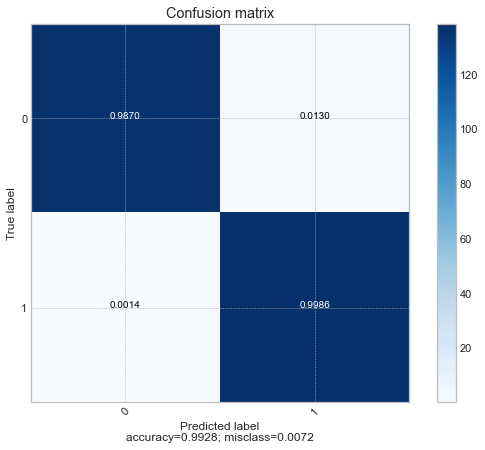

Confusion matrix:
[[136.798   1.802]
 [  0.193 138.407]]

              precision    recall  f1-score   support

           0     1.0000    0.9928    0.9964       138
           1     0.9929    1.0000    0.9964       139

    accuracy                         0.9964       277
   macro avg     0.9964    0.9964    0.9964       277
weighted avg     0.9964    0.9964    0.9964       277



In [69]:
xgb_model = XGBClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoost Classifier', xgb_model, 10, 100, verbose=False)

## 7.11 XGBoostRF Classifier

## 7.12 Real Model´s Performance

# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1 Random Search

## 8.2 Baseline Classifier - Majority Learner/ZeroR

In [78]:
# Baseline classifier y_test
counter = collections.Counter(y_test)
base_line= np.array( [ counter[0] / (counter[0] + counter[1]), counter[1] / (counter[0] + counter[1]) ] )
base_line.max()

0.8275

## 8.3 Final Model Training

# 9.0 MODEL TRANSLATION AND INTERPRETATION